In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing

import datetime
from kerastuner.tuners import RandomSearch

In [2]:
df = pd.read_csv('../../Data/CSV-files/dataset-of-00sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-90sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-60sv2.csv')
df.head(1)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,artist_popularity,artist_followers
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.27,1,0.0289,0.368,...,0.159,0.532,133.061,196707,4,30.88059,13,1,63,973747


In [3]:
def process_data(dataframe):
    data = dataframe.sample(frac=1)
    data.drop(["track","artist","uri"],axis=1,inplace=True)
    
    target = data.iloc[:,[15]]
    
    #Fjerner kolonnen target
    unscaled_inputs = data.loc[:,data.columns != 'target']
    
    #Skaler dataen, samler verdier rundt 0
    scaled_inputs = preprocessing.scale(unscaled_inputs)
    #scaled_inputs er typen array 
    
    samples_count = scaled_inputs.shape[0]
    train_samples_count = int(0.8*samples_count)
    validation_samples_count = int(0.1*samples_count)
    test_samples_count = samples_count - train_samples_count - validation_samples_count
    
    train_inputs = scaled_inputs[:train_samples_count]
    train_targets = target[:train_samples_count]

    validation_inputs = scaled_inputs[train_samples_count:train_samples_count+validation_samples_count]
    validation_targets = target[train_samples_count:train_samples_count+validation_samples_count]

    test_inputs = scaled_inputs[train_samples_count+validation_samples_count:]
    test_targets = target[train_samples_count+validation_samples_count:]
    
    np.savez('Spotify_data_train', inputs=train_inputs, targets=train_targets)
    np.savez('Spotify_data_validation', inputs=validation_inputs, targets=validation_targets)
    np.savez('Spotify_data_test', inputs=test_inputs, targets=test_targets)
    
    npz = np.load('Spotify_data_train.npz')
    train_inputs,train_targets = npz['inputs'].astype(np.float),npz['targets'].astype(np.int)

    npz = np.load('Spotify_data_validation.npz')
    validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

    npz = np.load('Spotify_data_test.npz')
    test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)
    
    return [train_inputs,train_targets,validation_inputs, validation_targets, test_inputs, test_targets ]

In [4]:
#Definerer variabler som brukes senere:
data = process_data(df)
train_inputs = data[0]
train_targets = data[1]
validation_inputs = data[2] 
validation_targets = data[3]
test_inputs = data[4]
test_targets = data[5]

In [5]:
def build_model():
    # Set the input and output sizes
    input_size = 17 # count of features
    output_size = 2 # count of targets
    # Use same hidden layer size for both hidden layers. Not a necessity.
    hidden_layer_size = 50 # counts of neurons

    # define how the model will look like
    #Stacker ulike lak med hidden layer "oppå" hverandre i modellen 
    model = tf.keras.Sequential([
        #tf.keras.Input(shape=(17,)),
        #tf.keras.layers.Dense(input_size=)?????
        # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
        # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',input_shape=(17,)), # 1st hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
        tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3nd hidden layer
        # the final layer is no different, we just make sure to activate it with softmax
        tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])
    
    return model

In [ ]:
#model = build_model()
#compile_model(model)
#history = fit_model(model)
#plot_history(history)
#evaluate_model()

In [6]:
model.summary()

NameError: name 'model' is not defined

In [7]:
def compile_model(model):
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
path = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [ ]:
#Kan også endre learning rate sånn:
#model.optimizer.lr = 0.1

In [8]:
def fit_model(model):
    # That's where we train the model we have built.
    # set the batch size
    batch_size = 300
    # set a maximum number of training epochs
    max_epochs = 10

    # fit the model
    # note that this time the train, validation and test data are not iterable
    history = model.fit(  train_inputs, # train inputs
                          train_targets, # train targets
                          batch_size=batch_size, # batch size
                          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
                          # callbacks are functions called by a task when a task is completed
                          # task here is to check if val_loss is increasing
                          #callbacks=[early_stopping], # early stopping
                          validation_data=(validation_inputs, validation_targets),# validation data
                          #callbacks=[tensorboard_callback],
                          verbose = 2# making sure we get enough information about the training process
              ) 
    return history

In [9]:
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    accuracy = history.history['accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, validation_loss, 'b-')
    plt.plot(epoch_count,accuracy)
    plt.legend(['Training Loss', 'Validation Loss','Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [10]:
def evaluate_model():
    test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
    print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Epoch 1/10
16/16 - 0s - loss: 0.5849 - accuracy: 0.7494 - val_loss: 0.4720 - val_accuracy: 0.8348
Epoch 2/10
16/16 - 0s - loss: 0.4016 - accuracy: 0.8412 - val_loss: 0.3256 - val_accuracy: 0.8637
Epoch 3/10
16/16 - 0s - loss: 0.3076 - accuracy: 0.8727 - val_loss: 0.2657 - val_accuracy: 0.8927
Epoch 4/10
16/16 - 0s - loss: 0.2831 - accuracy: 0.8835 - val_loss: 0.2524 - val_accuracy: 0.9029
Epoch 5/10
16/16 - 0s - loss: 0.2715 - accuracy: 0.8874 - val_loss: 0.2500 - val_accuracy: 0.8944
Epoch 6/10
16/16 - 0s - loss: 0.2629 - accuracy: 0.8921 - val_loss: 0.2420 - val_accuracy: 0.8978
Epoch 7/10
16/16 - 0s - loss: 0.2565 - accuracy: 0.8938 - val_loss: 0.2388 - val_accuracy: 0.8978
Epoch 8/10
16/16 - 0s - loss: 0.2507 - accuracy: 0.8967 - val_loss: 0.2364 - val_accuracy: 0.8978
Epoch 9/10
16/16 - 0s - loss: 0.2476 - accuracy: 0.8961 - val_loss: 0.2358 - val_accuracy: 0.8978
Epoch 10/10
16/16 - 0s - loss: 0.2424 - accuracy: 0.8987 - val_loss: 0.2332 - val_accuracy: 0.8995


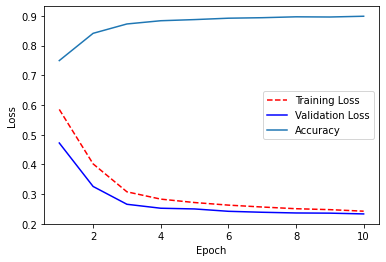

19/19 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9048

Test loss: 0.24. Test accuracy: 90.48%


In [11]:
model = build_model()
compile_model(model)
history = fit_model(model)
plot_history(history)
evaluate_model()

In [12]:
test_accuracy = model.evaluate(test_inputs, test_targets)
#print(model.metrics_names)

print(test_accuracy)

19/19 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.90 - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9048
[0.24212156236171722, 0.9047619104385376]


In [14]:
print(test_accuracy)
print(model.metrics_names)

[0.24212156236171722, 0.9047619104385376]
['loss', 'accuracy']


In [ ]:
def plot_value_array(i, predictions_array, true_label):
    true_label = test_targets[i]
    plt.grid(False)

    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.ylabel("{:2.0f}%".format(100*np.max(predictions_array),color=color))

    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')


In [ ]:
def plot_result(rows,cols):
    plt.figure(figsize=(2*2*cols, 2*rows))
    for i in range(rows*cols):
        plt.subplot(rows, 2*cols, 2*i+2)
        plot_value_array(i, predictions[i], test_targets)
    plt.tight_layout()
    plt.show()

In [ ]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_inputs)

In [ ]:
predictions[8]

In [ ]:
plot_result(5,5)

In [ ]:
def get_wrong_guess_data():
    wrong_guess = []
    for i in range(100):
        index = np.argmax(predictions[i])
        if(index!=test_targets[i]):
            arr = np.concatenate((test_inputs[i],test_targets[i])) 
            wrong_guess.append(arr)
            #wrong_guess.append(test_targets[i])
    return wrong_guess

In [16]:
def run_network(path):
    df = pd.read_csv(path)
    data = process_data(df)
    train_inputs = data[0]
    train_targets = data[1]
    validation_inputs = data[2] 
    validation_targets = data[3]
    test_inputs = data[4]
    test_targets = data[5]
    model = build_model()
    compile_model(model)
    history = fit_model(model)
    plot_history(history)
    evaluate_model()

Epoch 1/10
16/16 - 0s - loss: 0.5341 - accuracy: 0.7507 - val_loss: 0.4195 - val_accuracy: 0.8433
Epoch 2/10
16/16 - 0s - loss: 0.3643 - accuracy: 0.8637 - val_loss: 0.3091 - val_accuracy: 0.8739
Epoch 3/10
16/16 - 0s - loss: 0.3036 - accuracy: 0.8755 - val_loss: 0.2719 - val_accuracy: 0.8893
Epoch 4/10
16/16 - 0s - loss: 0.2878 - accuracy: 0.8814 - val_loss: 0.2578 - val_accuracy: 0.8961
Epoch 5/10
16/16 - 0s - loss: 0.2757 - accuracy: 0.8846 - val_loss: 0.2562 - val_accuracy: 0.8944
Epoch 6/10
16/16 - 0s - loss: 0.2672 - accuracy: 0.8891 - val_loss: 0.2503 - val_accuracy: 0.8961
Epoch 7/10
16/16 - 0s - loss: 0.2608 - accuracy: 0.8925 - val_loss: 0.2487 - val_accuracy: 0.8978
Epoch 8/10
16/16 - 0s - loss: 0.2558 - accuracy: 0.8940 - val_loss: 0.2452 - val_accuracy: 0.9063
Epoch 9/10
16/16 - 0s - loss: 0.2506 - accuracy: 0.8933 - val_loss: 0.2431 - val_accuracy: 0.9080
Epoch 10/10
16/16 - 0s - loss: 0.2481 - accuracy: 0.8957 - val_loss: 0.2416 - val_accuracy: 0.9012


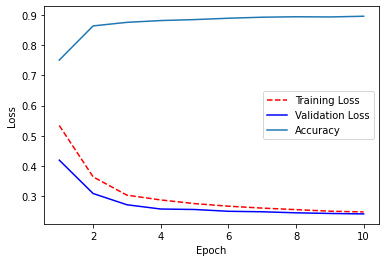

19/19 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.90 - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9048

Test loss: 0.24. Test accuracy: 90.48%


In [17]:
run_network('../../Data/CSV-files/dataset-of-00sv2.csv')